https://blog.futuresmart.ai/langgraph-tutorial-for-beginners#heading-graph-structures

In [ ]:
!pip install -U langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 11.7 MB/s eta 0:00:00


In [ ]:
 from typing import Annotated
 from typing_extensions import TypedDict
 from langgraph.graph import StateGraph, START, END
 from langgraph.graph.message import add_messages

In [ ]:
 class State(TypedDict):
     # 'messages' will store the chatbot conversation history.
     # The 'add_messages' function ensures new messages are appended to the list.
     messages: Annotated[list, add_messages]

 # Create an instance of the StateGraph, passing in the State class
 graph_builder = StateGraph(State)

In [ ]:
 !pip install -U langchain_anthropic
 from langchain_anthropic import ChatAnthropic

 llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 6.5 MB/s eta 0:00:00


In [ ]:
 def chatbot(state: State):
     # Use the LLM to generate a response based on the current conversation history.
     response = llm.invoke(state["messages"])

     # Return the updated state with the new message appended
     return {"messages": [response]}

 # Add the 'chatbot' node to the graph,
 graph_builder.add_node("chatbot", chatbot)

In [ ]:
 # For this basic chatbot, the 'chatbot' node is both the entry and finish point
 graph_builder.add_edge(START, "chatbot")
 graph_builder.add_edge("chatbot", END)

In [ ]:
 graph = graph_builder.compile()

In [ ]:
 from IPython.display import Image, display

 try:
     display(Image(graph.get_graph().draw_mermaid_png()))
     print("s")
 except Exception:
     # This requires some extra dependencies and is optional
     pass

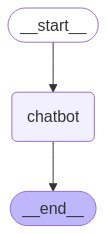

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
 while True:
     user_input = input("User: ")
     if user_input.lower() in ["quit", "exit", "q"]:
         print("Goodbye!")
         break

     # Process user input through the LangGraph
     for event in graph.stream({"messages": [("user", user_input)]}):
         for value in event.values():
             print("Assistant:", value["messages"][-1].content)

User: quit
Goodbye!


In [38]:
#pip install -U tavily-python langchain_community
from typing import Annotated
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2,tavily_api_key="<Tavily API key.See Norton Password Manager>")
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

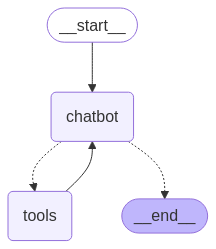

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

ANTHROPIC_API_KEY: ··········


In [40]:
while True:
     user_input = input("User: ")
     if user_input.lower() in ["quit", "exit", "q"]:
         print("Goodbye!")
         break

     # Process user input through the LangGraph
     for event in graph.stream({"messages": [("user", user_input)]}):
         for value in event.values():
             print("Assistant:", value["messages"][-1].content)

User: Who is Messi?
Assistant: [{'text': "To provide you with accurate and up-to-date information about Messi, I'll need to search for the most recent details. Let me do that for you.", 'type': 'text'}, {'id': 'toolu_012WJpNFWtmmuG3PC5Kp1ka1', 'input': {'query': 'Who is Lionel Messi current information'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"title": "Lionel Messi - Wikipedia", "url": "https://en.wikipedia.org/wiki/Lionel_Messi", "content": "Lionel MessiMessi with Argentina at the 2022 FIFA World CupPersonal informationFull nameLionel Andrés Messi[1]Date of birth(1987-06-24) 24 June 1987 (age 37)[1]Place of birthRosario, ArgentinaHeight1.70 m (5 ft 7 in)[1]Position(s)ForwardTeam informationCurrent teamInter MiamiNumber10Youth career1992–1995Grandoli1995–2000Newell's Old Boys2000–2004BarcelonaSenior career*YearsTeamApps(Gls)2003–2004Barcelona C10(5)2004–2005Barcelona B22(6)2004–2021Barcelona520(474)2021–2023Paris [...] Lionel Andrés \"Leo\" Messi[note 

In [29]:
import getpass
import os
#See Norton Password Manager forAnthropic API key

if "ANTHROPIC_API_KEY" not in os.environ:
    os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Enter your Anthropic API key: ")

In [33]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

In [34]:
os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Enter your Anthropic API key: ")

Enter your Anthropic API key: ··········
